# Deep Learning with Python
# 6.4.0 - Advanced RNNs

Will be using three different techniques to improve RNN performance on a **sequence regression** task - predicting the temperature using past values of temperature, pressure, wind, and other climate data.

These techniques are
1. Recurrent Dropout - a specific, built-in way to use dropout to fight overfitting in recurrent layers.
2. Stacking recurrent layers - increases the representational power of the network (albeit at the cost of higher computational complexity).
3. Bidirectional recurrent layers - present same information to recurrent network in different ways, increasing accuracy and mitigating overfitting.

## Loading Temperature Data

In [4]:
import os

# Path to directory containing the CSV file
data_dir = '/Users/saads/OneDrive/Desktop/DL-Python-Repo/FYP-DL/DL-Python-Book/chapter-6'

# Actual CSV file
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [5]:
# Open the file to read data from it
f = open(fname)

# Read each line into a data structure
data = f.read()

# Once all data read, close the filestream
f.close()

In [6]:
# Break data into individual lines based on newline character
lines = data.split('\n')

# The first line is the header, containing labels for the 
# data in each 'column' in the csv file. Read as list of headings
header = lines[0].split(',')

# The actual training examples begin after the header
lines = lines[1:]

In [7]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


Each column contains a piece of weather data about the location - date/time/pressure/temperature/temperature at a pot?/temperature during dew/etc.

In [8]:
print("Number of training examples = ", len(lines))

Number of training examples =  420551


In [9]:
# Converting all lines into a `numpy` array that can be used
# as input for a tensor
import numpy as np

In [10]:
# One column foreach weather property in header - dropping the date time column
# One row for each training example
float_data = np.zeros((len(lines), len(header) - 1))

Convert the `lines`list into a list of tuples, where each line is assigned a numeric index. Then split each line into a list of values based on the `,` delimiter, and except for the `Date/Time` value, convert all values to a `float32` value and append it to the list of data at the specified index. 

In [11]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plotting Temperature

In [12]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Variation of Temperature')

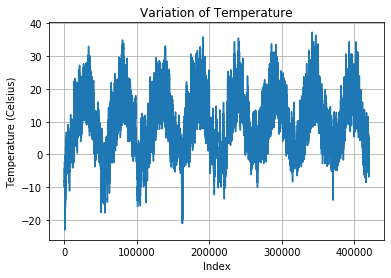

In [14]:
temp = float_data[:, 1] # temperature in degrees Celsius
plt.plot(range(len(temp)), temp)
plt.grid(True); plt.xlabel('Index'); plt.ylabel('Temperature (Celsius)')
plt.title('Variation of Temperature')

Periodicity of the temperature over the year can be clearly seen. 

Text(0.5, 1.0, 'Temperature Over 10 Days')

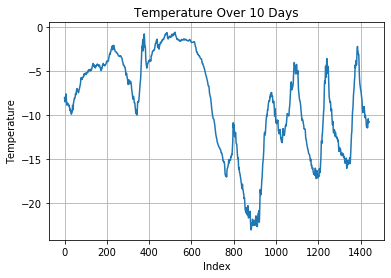

In [16]:
# Plotting the temperature for the first 10 days of timeseries
# Recorded every 10 minutes - 1440 minutes per day - so 144 data points per day
plt.plot(range(1440), temp[:1440])
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.grid(True)
plt.title('Temperature Over 10 Days')